<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/Final_Version_2(Correlation_based_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters
import random


In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def corr_calculator(x1, x2):
  '''
  give this function tow signals. it will compute the correlation of two signals.
  your signals can have multiple channels. in that case the correlation of the channels
  will be computed element wise (the channel number one with channel number one and etc.)
  '''


  tau = 0
  corr = []
  x1_mean = x1.mean(axis=0)
  x2_mean = x2.mean(axis=0)
  x1_std = x1.std(axis=0)
  x2_std = x2.std(axis=0)
  for tau in range(x1.shape[0]):
    corr.append(  (np.mean(np.roll(x1,tau, axis=0)*x2, axis=0) - x1_mean*x2_mean)/(x1_std*x2_std)  )

  corr = np.array(corr)


  return corr

In [0]:
def History_plotter(his):
  global History
  his_list = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  for i, name in enumerate(his_list):
    History[i]+=(his.history[name])
  plt.figure(figsize=(8, 5))
  plt.plot(np.array(History).T, '-')
  plt.legend(his_list)


In [0]:
under_sample =1
t = np.linspace(0,3,int(7200/under_sample))
f = np.linspace(1/3, 2400, int(7200/under_sample))

In [0]:
Data = []
class_list = ['none'] + [ 'train_data_class{}'.format(i+1) for i in range(4)]
Label = []


for i in range(15):
  subj = datafetch.fetch_subject(i+1)
  for class_ in range(1,5):
    for trial in range(25):
      Data.append(subj[class_list[class_]][trial][::under_sample, :])
      Label += [class_]

Data = np.array(Data)
Label = np.array(Label)

rnd = [i for i in range(1500)]
np.random.shuffle(rnd)

Data = Data[rnd]
Label = Label[rnd]

In [0]:
classes_mean = [ np.zeros((7200, 63)) for i in range(5)]
class_count = np.zeros((5))

for i in range(len(Data)):
  result = classes_mean[Label[i]]
  result += np.array(Data[i])
  classes_mean[Label[i]] = result
  class_count[Label[i]] +=1 

class_count[0] +=1

for i, elem in enumerate(classes_mean):
  elem /= class_count[i]

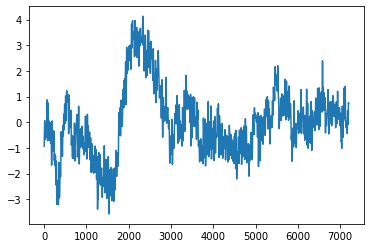

In [29]:
plt.plot(classes_mean[2][:,13])

In [58]:
#for i in range(len(Data)):
%cd /content/drive/My Drive/EEG_BCI
corr_list = []
for i in range(len(Data)):
  corr = corr_calculator(Data[i][::6,:], classes_mean[Label[i]][::6,:])
  corr_list.append(corr)

  if i%50 ==0:
    print(i)


np.save('corr_list', corr_list)

/content/drive/My Drive/EEG_BCI
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [0]:
x_train, x_test, y_train, y_test = train_test_split(corr_list, Label, test_size = 0.1)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
History = [[] for i in range(4)]
#del Data, Label

In [0]:
from pandas import DataFrame

In [0]:
import tensorflow as tf
from tensorflow import keras


In [0]:
global History
History = [[] for i in range(4)]

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/6),63) ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=30, kernel_size=5, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.MaxPool1D(pool_size=2))



model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=3))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(70, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(50, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(20, activation=active,  kernel_initializer="he_normal" ))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d_1 (Average (None, 1200, 63)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1200, 63)          252       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1196, 30)          9480      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 398, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 396, 20)           1820      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 132, 20)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 132, 20)          

In [0]:
opt = keras.optimizers.Adam( lr=0.000001)
model.compile(optimizer='adam', 
              metrics= ['accuracy'],
              loss= 'sparse_categorical_crossentropy')

In [102]:
his = model.fit(x_train, y_train-1, epochs=50, batch_size=5, validation_data=(x_test, y_test-1))

Epoch 1/50
270/270 [==============================] - 8s 31ms/step - loss: 0.6104 - accuracy: 0.7770 - val_loss: 0.7106 - val_accuracy: 0.7000
Epoch 2/50
270/270 [==============================] - 8s 31ms/step - loss: 0.6087 - accuracy: 0.7778 - val_loss: 0.5949 - val_accuracy: 0.7533
Epoch 3/50
270/270 [==============================] - 8s 31ms/step - loss: 0.5844 - accuracy: 0.8022 - val_loss: 0.7357 - val_accuracy: 0.6800
Epoch 4/50
270/270 [==============================] - 8s 31ms/step - loss: 0.6113 - accuracy: 0.7770 - val_loss: 0.7959 - val_accuracy: 0.6600
Epoch 5/50
270/270 [==============================] - 8s 30ms/step - loss: 0.5449 - accuracy: 0.7904 - val_loss: 1.0592 - val_accuracy: 0.5867
Epoch 6/50
270/270 [==============================] - 8s 31ms/step - loss: 0.5924 - accuracy: 0.7919 - val_loss: 0.9317 - val_accuracy: 0.6000
Epoch 7/50
270/270 [==============================] - 8s 31ms/step - loss: 0.5717 - accuracy: 0.7911 - val_loss: 0.6814 - val_accuracy: 0.7200

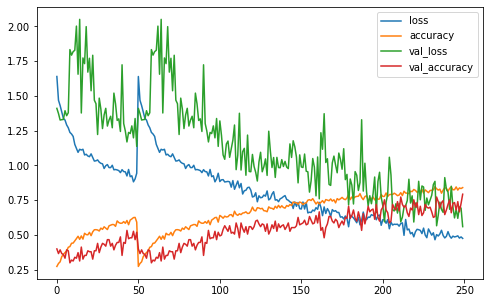

In [103]:
History_plotter(his)


In [0]:
model.save('acc75_best.h5')

#Results

In [0]:
mean_over_mean = np.sum(classes_mean, axis=0)/4

(7200, 63)

In [105]:
corr_test = []
for i in range(1350,1500):
  corr = corr_calculator(Data[i][::6,:], mean_over_mean[::6,:])
  corr_test.append(corr)

  if i%50 ==0:
    print(i)

corr_test = np.array(corr_test)

1350
1400
1450


In [106]:
corr_test.shape

(150, 1200, 63)

In [0]:
y_pred_test = model.predict(corr_test)
y_pred_test = np.argmax(y_pred_test, axis=1) + 1


In [108]:
confusion_matrix(Label[1350:], y_pred_test)

array([[ 4,  7, 22,  5],
       [ 3, 13, 15,  7],
       [ 2,  8, 30,  2],
       [ 6,  6, 15,  5]])

In [109]:
print(classification_report(Label[1350:], y_pred_test))

              precision    recall  f1-score   support

           1       0.27      0.11      0.15        38
           2       0.38      0.34      0.36        38
           3       0.37      0.71      0.48        42
           4       0.26      0.16      0.20        32

    accuracy                           0.35       150
   macro avg       0.32      0.33      0.30       150
weighted avg       0.32      0.35      0.31       150



# File Generator

In [0]:
Data_test = []
class_list = ['test_data']


for i in range(15):
  subj = datafetch.fetch_subject(i+1)
  corr_result = []
  for subject in range(60):
    corr = corr_calculator(subj[subject][::6,:], mean_over_mean[::6,:])
    corr_result.append(corr)


  DATA = subj['test_data']
  label = model.predict(DATA)
  label = np.argmax(label,axis=1)+1
  np.savetxt( 'subject_{}.csv'.format(i+1), label)



# 62%

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/6),63) ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=30, kernel_size=5, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.MaxPool1D(pool_size=2))



model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=3))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(70, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(50, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(20, activation=active,  kernel_initializer="he_normal" ))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


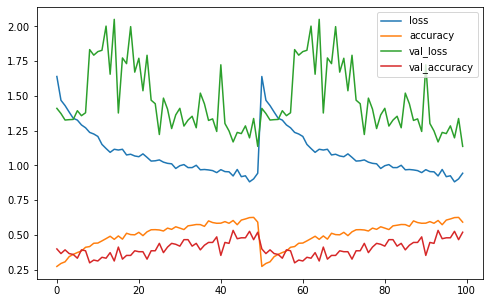

In [80]:
History_plotter(his)
